# Modules

In [4]:
import requests
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u

from scipy.interpolate import splev, splrep
from scipy.ndimage import gaussian_filter1d
import scipy.optimize as opt
from scipy.signal import find_peaks

import glob

from pdastro import *

# Definitions

In [8]:
def diff(params, f_tmp, f_tmp_err, f_obs, f_obs_err):
    """calculate the difference between two light curves"""
    a, b = params
    f_obs_new = a * f_obs + b
    err = np.sqrt(f_tmp_err**2+f_obs_err**2)
    chi2 = (f_obs_new - f_tmp)**2 / err**2
    
    return np.sum(chi2)


def find_t_peak(t, f, t_range=None):
    if t_range is None:
        t_peak = t[np.argmax(f)]
    else:
        t_min = t_range[0]
        t_max = t_range[1]
        f = f[(t<t_max) & (t>t_min)]
        t = t[(t<t_max) & (t>t_min)]
        t_peak = t[np.argmax(f)]
    
    return t_peak


def find_t_shift(t1, f1, t2, f2, t_range=None):
    t_peak1 = find_t_peak(t1, f1, t_range=t_range)
    t_peak2 = find_t_peak(t2, f2, t_range=t_range)
    
    return t_peak2 - t_peak1


def get_tshift_scale_offset(t1, f1, f1_err, t2, f2, f2_err, t_range=None, t_peaks=None):
    """get optimized scale factor tshift, a, b
    t1, f1: template 
    t2, f2: f2_new = a * f2 + b
    """

    if t_peaks is None:
        if t_range is None:
            tshift = find_t_shift(t1, f1, t2, f2)
        elif t_range is not None:
            tshift = find_t_shift(t1, f1, t2, f2, t_range=t_range)
    elif t_peaks is not None:
        tshift = t_peaks[1] - t_peaks[0]
    
    t2_shifted = t2 - tshift

    tmin = max(t1.min(), t2_shifted.min())
    tmax = min(t1.max(), t2_shifted.max())
    
    t_range = t2_shifted[(t2_shifted>tmin) & ((t2_shifted<=tmax))]
    
    f1_new = splev(t_range, splrep(t1[::2], f1[::2], k=1))
    f1_new_err = splev(t_range, splrep(t1[::2], f1_err[::2], k=1))
    f2_new = f2[(t2_shifted>tmin) & ((t2_shifted<=tmax))]
    f2_new_err = f2_err[(t2_shifted>tmin) & ((t2_shifted<=tmax))]
    
    # get optimzied scale f2_new = a * f2 + b
    guess = (1, 0)
    res = opt.minimize(diff, guess, args=(f1_new, f1_new_err, f2_new, f2_new_err))
    a, b = res['x'][0], res['x'][1]
    
    return tshift, a, b

In [10]:
def lc_indices(df, n_sigma=3.0, nerr_sigma=3.0):
    "return the indices of the table of usable values"
    
    jyas2_med = np.nanmedian(df['Jyas2'])
    jyas2_std = np.nanstd(df['Jyas2'])
    jyas2err_med = np.nanmedian(df['Jyas2_err'])
    jyas2err_std = np.nanstd(df['Jyas2_err'])

    if nerr_sigma!=None:
        inds = np.where((df['Jyas2_err']< jyas2err_med + nerr_sigma*jyas2err_std) & (abs(df['Jyas2'])< jyas2_med + n_sigma*jyas2_std))[0]
    else:
        # inds = np.where((df['Jyas2_err']< jyas2err_med + 0.34e-6) & (abs(df['Jyas2'])< jyas2_med + n_sigma*jyas2_std))[0]   # this was for ec0814
        # inds = np.where((abs(df['Jyas2'])< jyas2_med + n_sigma*jyas2_std) & (df['Jyas2_err']<1.0e-6))[0]
        inds = np.where((df['fluxADU']< 1000) & (df['Jyas2_err']<1.0e-6))[0]
        
    return(inds)


def get_bins(df, t):
    t_range = np.linspace(min(t),max(t),100)
    skip_inds = []
    bins_t = []
    t_bvals = [t_range[0]]
    for i in range(len(t_range)-1):
        # if i not in skip_inds:
            lo_i = i
            skip_inds.append(i)
            up_i = i+1
            # bin_i = np.where((df.t['mjd']>t_range[lo_i]) & (df.t['mjd']<t_range[up_i]))[0]
            bin_i = df.ix_inrange('mjd', lowlim=t_range[lo_i], uplim=t_range[up_i])
            while len(bin_i)<50 and up_i!=len(t_range)-1:
                skip_inds.append(up_i)
                up_i += 1
                bin_i = df.ix_inrange('mjd', lowlim=t_range[lo_i], uplim=t_range[up_i])
                
            bins_t.append(bin_i)
            t_bvals.append(t_range[up_i])
    return(bins_t, t_bvals)


def get_LCbins(df, bin_sz):

    sort_inds = df.ix_sort_by_cols('mjd')

    bins_inds = []
    
    for i in range(0, len(sort_inds), bin_sz):
        if len(sort_inds) - (i+bin_sz) < bin_sz or len(sort_inds) - i < bin_sz:
            bins_inds.append(sort_inds[i:])
            break
        else:
            bins_inds.append(sort_inds[i:i + bin_sz])

    return(bins_inds)

In [12]:
def convert_Jy2mag(x_jy):
    # x_jy in micro-janskys
    mag = 23.9 - 2.5*np.log10(x_jy*1e6)
    return('{:.2f}'.format(round(mag, 2)))



def get_mean_pix(img, x, y):
    """ get mean pixel values over 9 nearby pixels centered at (x, y)
        img: array
        x, y center"""
    mean = (img[y, x] + img[y, x-1] + img[y, x+1]
          + img[y-1,x]+ img[y-1,x-1]+ img[y-1,x+1]
          + img[y+1,x]+ img[y+1,x-1]+ img[y+1,x+1]).astype(np.float32)/9
    return mean

# Combine Light Curves -- First Iteration

### Segment 1

In [45]:
### Read in light curves -- ec0915 ccd 54, focused on big peak

url1 = 'https://stsci-transients.stsci.edu/eta/etalc/results/rod_test/poly1_g/ec0915/54/ec0915a54_poly1pos_g_tmpl523730.html'
html1 = requests.get(url1).content
df_table1 = pd.read_html(html1)[-1]


IDs_good_fits_poly1 = [12, 13, 17, 18, 19, 25, 26, 27, 31, 35, 36, 37, 38, 
                       59, 61, 62, 63, 64, 72, 73, 74, 75, 77, 88, 90, 
                       105, 106, 137, 190, 191, 950, 952, 999, 998, 996]

df_list1 = []
for i in IDs_good_fits_poly1:
    group_i = df_table1['group'][i]
    ID_i = df_table1['ID'][i]
    
    url = 'https://stsci-transients.stsci.edu/eta/etalc/results/rod_test/poly1_g/ec0915/54/ec0915a54_poly1pos_g_tmpl523730_ID'+str(ID_i)+'_lc.txt'
    temp_tab = pd.read_csv(url, sep='\s+')
    df_list1.append(temp_tab)


### Want to work with micro-Jansky
for df in df_list1:
    df['mJyas2'] = df['Jyas2']*1e6
    df['mJyas2_err'] = df['Jyas2_err']*1e6

In [47]:
### Loop through and see the individual light curves
### Figure out uncertainty cuts to find the peaks

n_sigma1 = None
nerr_sigma1 = None

# for df in df_list1:
#     print(df['ID'][0])
    
#     # plt.errorbar(df['mjd'], df['Jyas2'], yerr=df['Jyas2_err'], fmt='o', ecolor='black', color='blue')

#     inds_sig = lc_indices(df, n_sigma=n_sigma1, nerr_sigma=nerr_sigma1)
#     plt.errorbar(df['mjd'][inds_sig], df['Jyas2'][inds_sig], yerr=df['Jyas2_err'][inds_sig], fmt='--o', ecolor='black', color='orange')
    
#     plt.axhline(y=0, linestyle='--', color='black')

#     peak_t1 = find_t_peak(df['mjd'][inds_sig].values, df['Jyas2'][inds_sig].values)
#     plt.axvline(x=peak_t1,color='red')
    
#     plt.show()

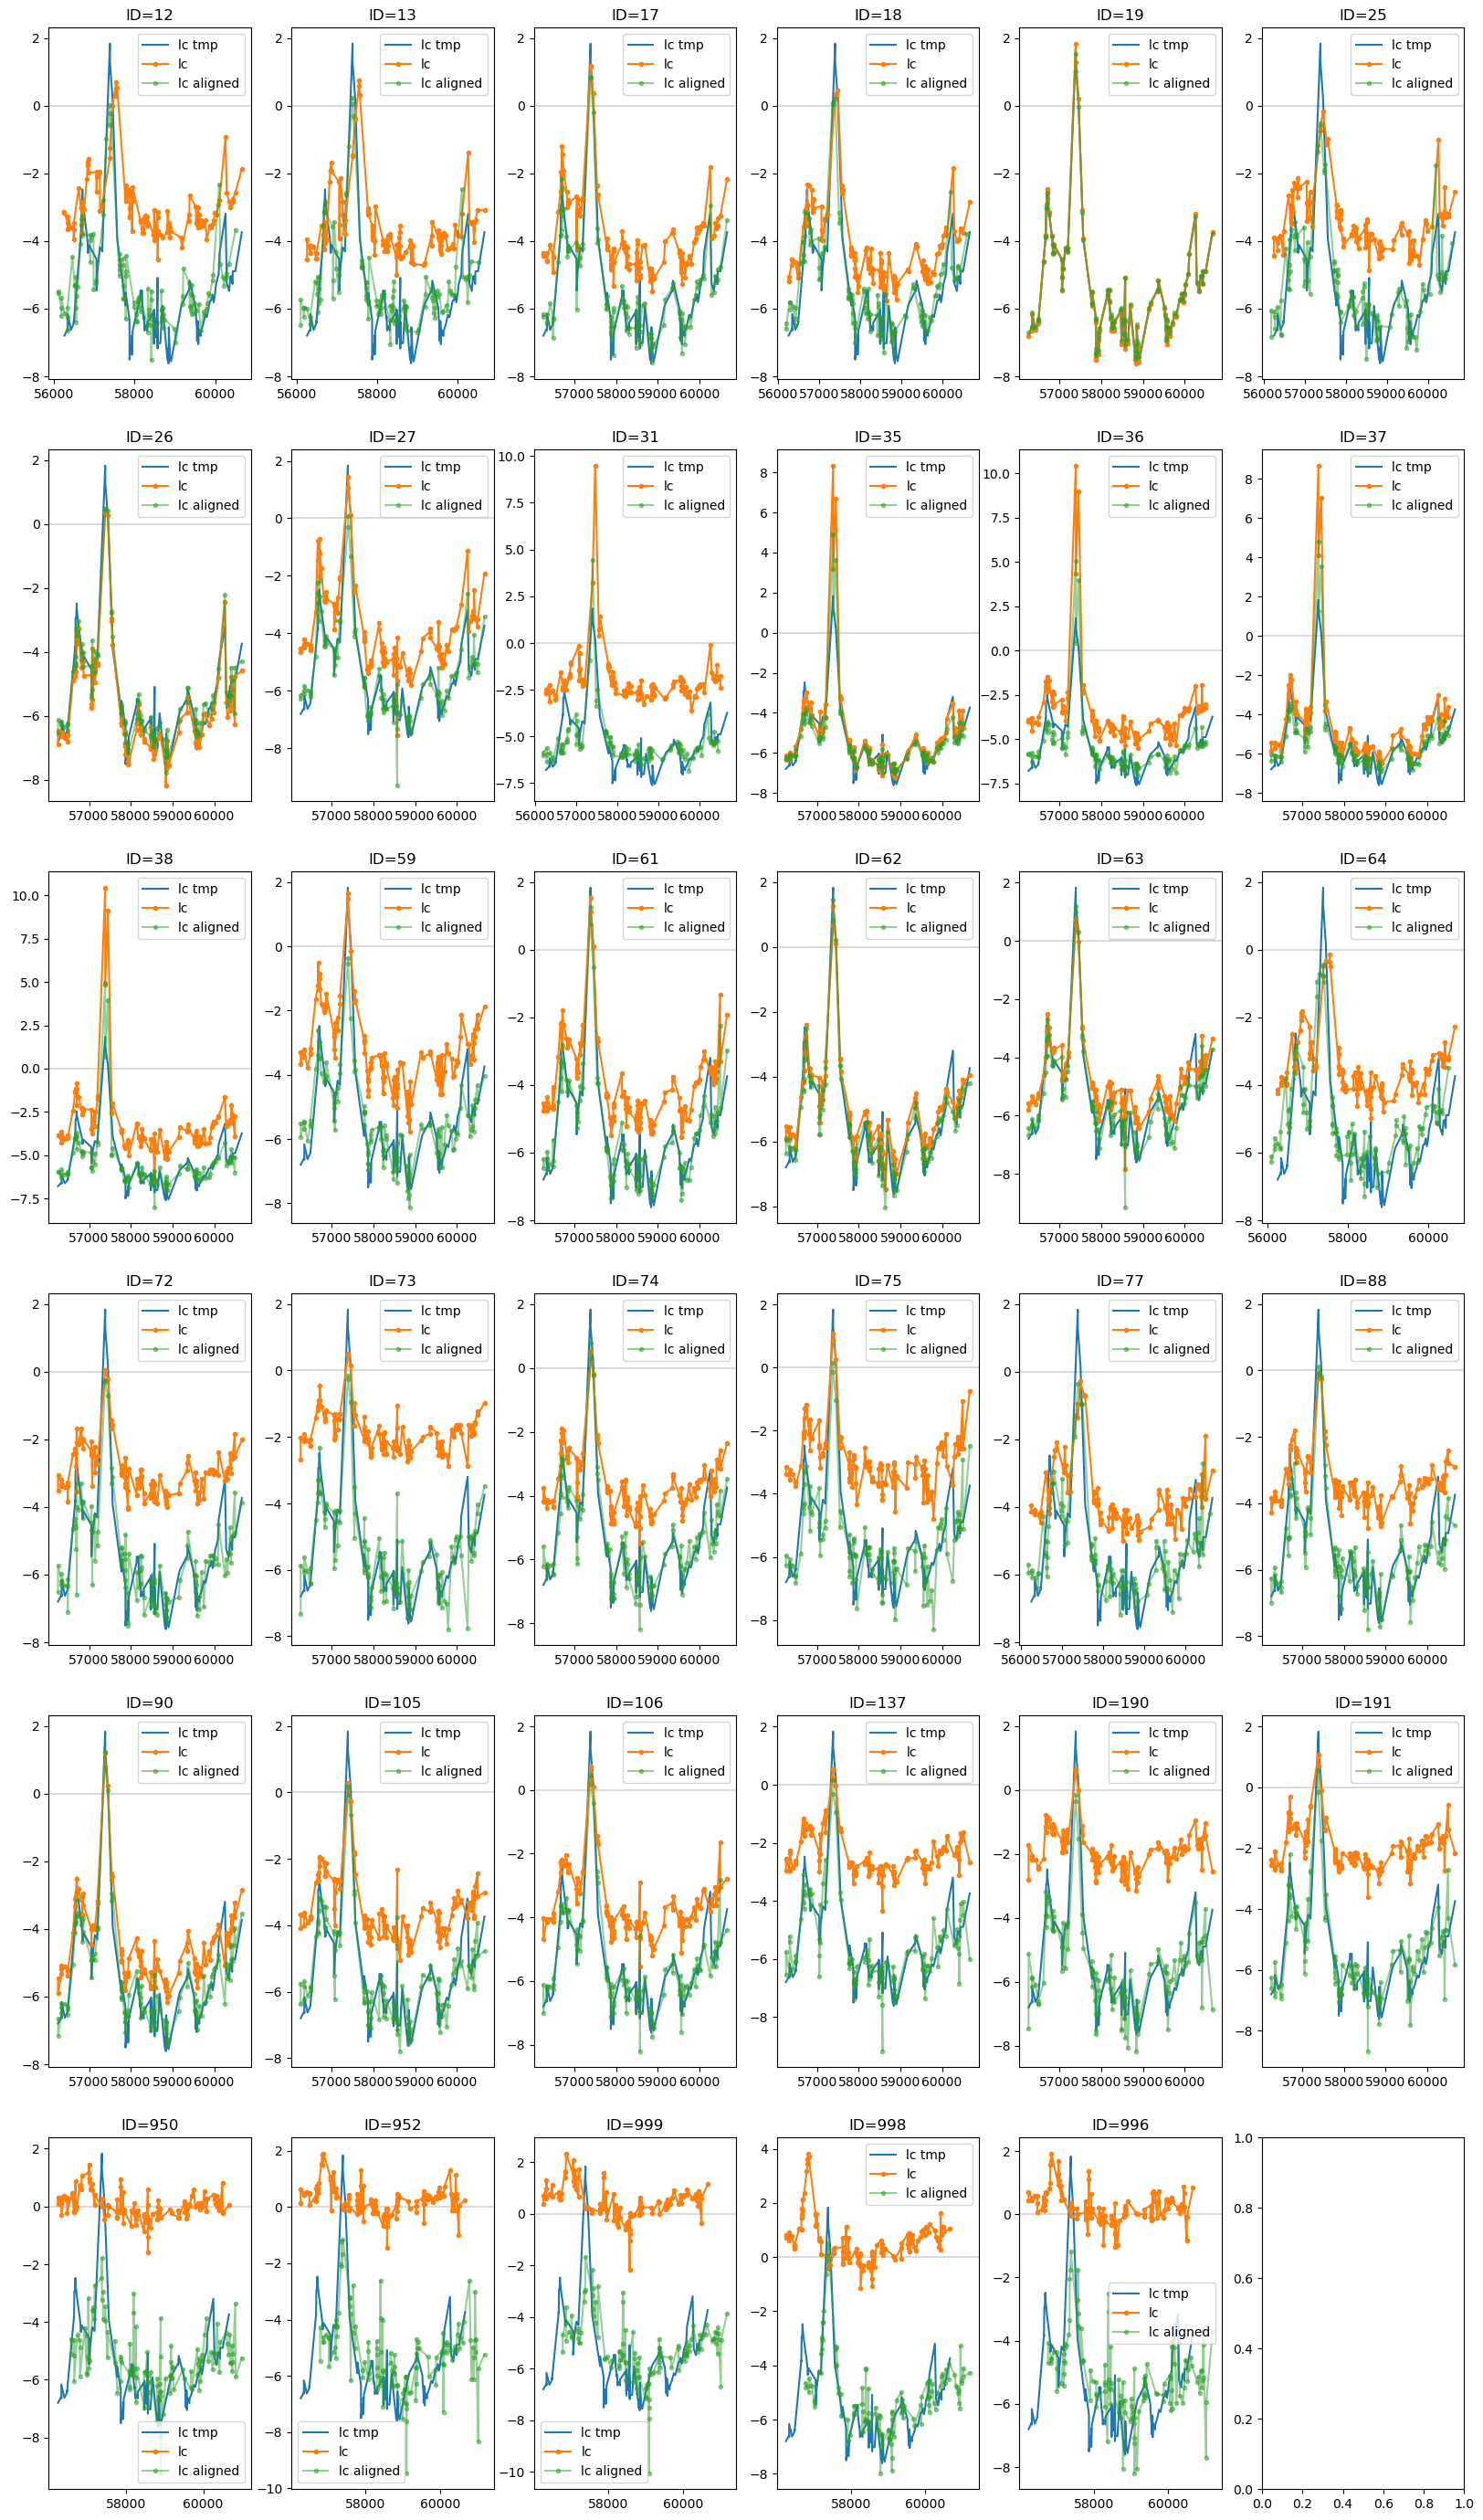

In [49]:
# Find the shift and fitting parameters for each light curve compared to the first one
temp_i = np.where(df_table1.loc[IDs_good_fits_poly1,'ID']==19)[0][0]
temp_ID = df_list1[temp_i]['ID'][0]
g1_inds = lc_indices(df_list1[temp_i], n_sigma=n_sigma1, nerr_sigma=nerr_sigma1)
t1 = df_list1[temp_i]['mjd'][g1_inds].values
f1 = df_list1[temp_i]['mJyas2'][g1_inds].values
f1_err = df_list1[temp_i]['mJyas2_err'][g1_inds].values


fig, axs = plt.subplots(6, 6, figsize=(20, 35))
axs = axs.flatten() 

tshifts_54 = []
a_norms_54 = []
b_offsets_54 = []

for i, df in enumerate(df_list1):
    g_inds = lc_indices(df, n_sigma=n_sigma1, nerr_sigma=nerr_sigma1)
    t2 = df['mjd'][g_inds].values
    f2 = df['mJyas2'][g_inds].values
    f2_err = df['mJyas2_err'][g_inds].values

    tshift, a, b = get_tshift_scale_offset(t1, f1, f1_err, t2, f2, f2_err)

    tshifts_54.append(tshift)
    a_norms_54.append(a)
    b_offsets_54.append(b)
    
    ax = axs[i]
    ax.plot(t1, f1, label='lc tmp')
    ax.errorbar(t2, f2, label='lc', fmt='.-')
    ax.errorbar(t2-tshift, f2*a + b, alpha=.5, label='lc aligned', fmt='.-')

    #-------
    # ax.axvline(x=57452, color='k', linewidth=.2)
    # ax.axvline(x=56745, color='k', linewidth=.2, label='tmpl')
    ax.axhline(y=0, color='k', linewidth=.2)

    i_ID = str(df['ID'][0])
    ax.legend()
    ax.set_title(f'ID={i_ID}')

plt.show()

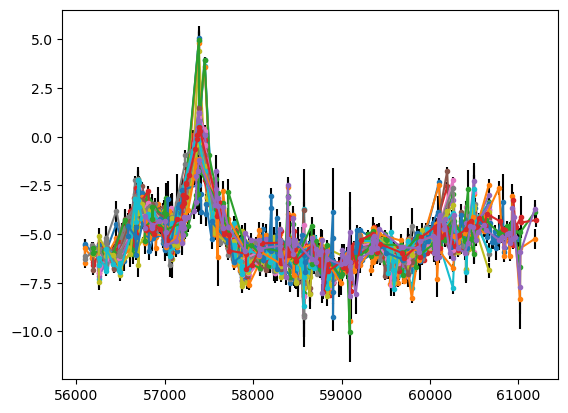

In [55]:
for i in range(len(tshifts_54)):
    df = df_list1[i]
    i_inds = lc_indices(df, n_sigma=n_sigma1, nerr_sigma=nerr_sigma1)
    
    tshift_i = tshifts_54[i]
    a_i = a_norms_54[i]
    b_i = b_offsets_54[i]
    t_new = df['mjd'][i_inds] - tshift_i
    f_new = a_i*df['mJyas2'][i_inds]+b_i
    ferr_new = a_i*df['mJyas2_err'][i_inds]
    df.loc[i_inds,'new_mjd_1'] = t_new
    df.loc[i_inds,'new_mJyas2_1'] = f_new
    df.loc[i_inds,'new_mJyas2_err_1'] = ferr_new
    plt.errorbar(t_new, f_new, yerr=ferr_new, fmt='.-', ecolor='black')
    # plt.ylim(-3.0e-6,4.0e-6)
# plt.xlim(57650,57800)

In [57]:
### Put combined data into a data frame

tls1 = np.concatenate([i['new_mjd_1'][lc_indices(i, n_sigma=n_sigma1, nerr_sigma=nerr_sigma1)] for i in df_list1])
fls1 = np.concatenate([i['new_mJyas2_1'][lc_indices(i, n_sigma=n_sigma1, nerr_sigma=nerr_sigma1)] for i in df_list1])
ferrls1 = np.concatenate([i['new_mJyas2_err_1'][lc_indices(i, n_sigma=n_sigma1, nerr_sigma=nerr_sigma1)] for i in df_list1])

ord_inds1 = tls1.argsort()
tls1 = tls1[ord_inds1]
fls1 = fls1[ord_inds1]
ferrls1 = ferrls1[ord_inds1]


comb1_data = {'mjd': tls1, 'mJyas2': fls1, 'mJyas2_err': ferrls1}
comb1 = pdastrostatsclass()
comb1.t = comb1.t.assign(**comb1_data)



### Use sigmacutloop function in pdastro to calculate the combined light curve

# bins1, t_bvals1 = get_bins(comb1, tls1)
bins1 = get_LCbins(comb1,45)
tmed1 = []
fmed1 = []
fmed_err1 = []
workinds1 = []
badinds1 = []

for i in range(len(bins1)):
    bin_i = bins1[i]
    comb1.calcaverage_sigmacutloop('mJyas2', indices=bin_i, noisecol='mJyas2_err', percentile_cut_firstiteration=70, Nsigma=3.0)
    tmed1.append(np.average(comb1.t.loc[bin_i,'mjd'], weights=1-comb1.t.loc[bin_i,'mJyas2_err']/max(comb1.t.loc[bin_i,'mJyas2_err'])))
    fmed1.append(comb1.statparams['mean'])
    fmed_err1.append(comb1.statparams['mean_err'])
    workinds1.append(comb1.statparams['ix_good'])
    badinds1.append(comb1.statparams['ix_clip'])


tmed1 = np.array(tmed1)
fmed1 = np.array(fmed1)
fmed_err1 = np.array(fmed_err1)


### Find the peaks in combined light curve

tpeak1 = find_t_peak(tmed1, fmed1)

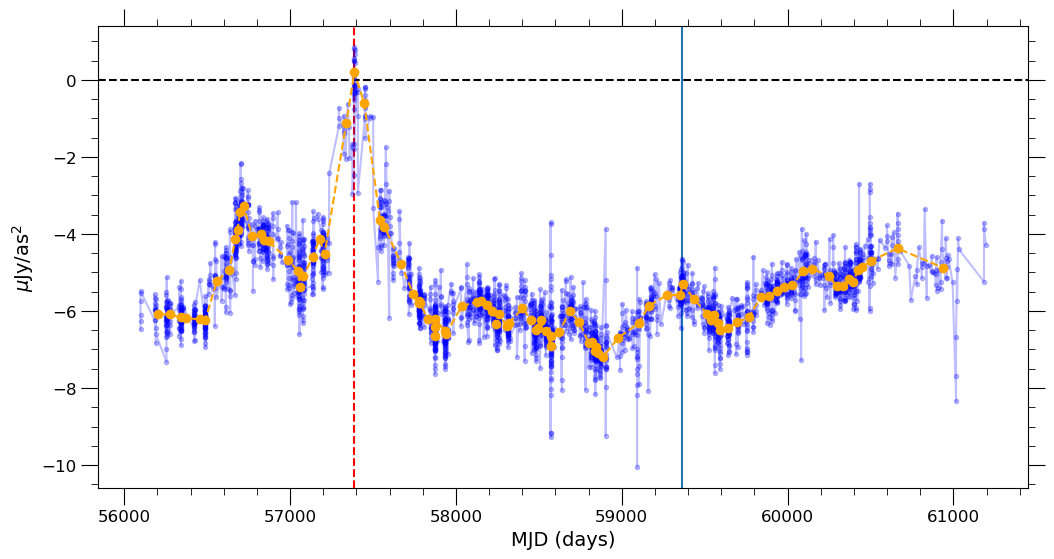

In [208]:
### Plot the combined light curve

pl_fig, pl_ax = plt.subplots(dpi = 100, figsize = [12,6])
pl_ax.minorticks_on()
pl_ax.tick_params(axis='x', labelsize=12)
pl_ax.tick_params(axis='y', labelsize=12)
pl_ax.tick_params(which='major',bottom='on',top='on',left='on',right='on',length=12)
pl_ax.tick_params(which='minor',bottom='on',top='on',left='on',right='on',length=5)
pl_ax.set_xlabel('MJD (days)', fontsize = 14)
pl_ax.set_ylabel('$\mu$Jy/as$^2$', fontsize = 14)
# pl_ax.set_title('Light Curve of filter g', x=0.4, y=0.9, fontsize = 16)
pl_ax.ticklabel_format(axis='both', style='plain')

winds1 = [i for bn in workinds1 for i in bn]

pl_ax.errorbar(comb1.t.loc[winds1,'mjd'], comb1.t.loc[winds1,'mJyas2'], fmt='.-', color='blue', alpha=0.25)
pl_ax.axhline(y=0, linestyle='--', color='black')
pl_ax.errorbar(tmed1, fmed1, fmt='--o', ecolor='black', color='orange') #,yerr=fmed_err1
pl_ax.axvline(x=tpeak1, color='red', linestyle='--')
# pl_ax.legend(fontsize = 14)

# pl_fig.savefig('ec0915_LC.png', bbox_inches = 'tight', dpi=100)
# pl_ax.axvline(60670)
pl_ax.axvline(59365)

### Segment 2

In [67]:
### Read in light curves -- ec0915 ccd 57, focused on before big peak

url2 = 'https://stsci-transients.stsci.edu/eta/etalc/results/rod_test/poly1_g/ec0915/57/ec0915a57_poly1pos_g_tmpl523730.html'
html2 = requests.get(url2).content
df_table2 = pd.read_html(html2)[-1]

# IDs_good_fits_57 = [117, 119, 120, 135, 137, 152, 155]
IDs_good_fits_57 = [120, 135, 137, 155]

df_list2 = []
for i in IDs_good_fits_57:
    group_i = df_table1['group'][i]
    ID_i = df_table1['ID'][i]
    
    url = 'https://stsci-transients.stsci.edu/eta/etalc/results/rod_test/poly1_g/ec0915/57/ec0915a57_poly1pos_g_tmpl523730_ID'+str(ID_i)+'_lc.txt'
    temp_tab = pd.read_csv(url, sep='\s+')
    df_list2.append(temp_tab)


### Want to work with micro-Jansky
for df in df_list2:
    df['mJyas2'] = df['Jyas2']*1e6
    df['mJyas2_err'] = df['Jyas2_err']*1e6

In [69]:
### Loop through and see the individual light curves
### Figure out uncertainty cuts to find the peaks


n_sigma2 = None
nerr_sigma2 = None

# for i in df_list2:
#     df = i
#     print(df['ID'][0])
    
#     # plt.errorbar(df['mjd'], df['mJyas2'], yerr=df['mJyas2_err'], fmt='o', ecolor='black', color='blue')

#     inds_sig = lc_indices(df, n_sigma=n_sigma2, nerr_sigma=nerr_sigma2)
#     plt.errorbar(df['mjd'][inds_sig], df['mJyas2'][inds_sig], yerr=df['mJyas2_err'][inds_sig], fmt='--o', ecolor='black', color='orange')
    
#     plt.axhline(y=0, linestyle='--', color='black')

#     peak_t2 = find_t_peak(df['mjd'][inds_sig].values, df['mJyas2'][inds_sig].values)
#     plt.axvline(x=peak_t2,color='red')
    
#     plt.show()

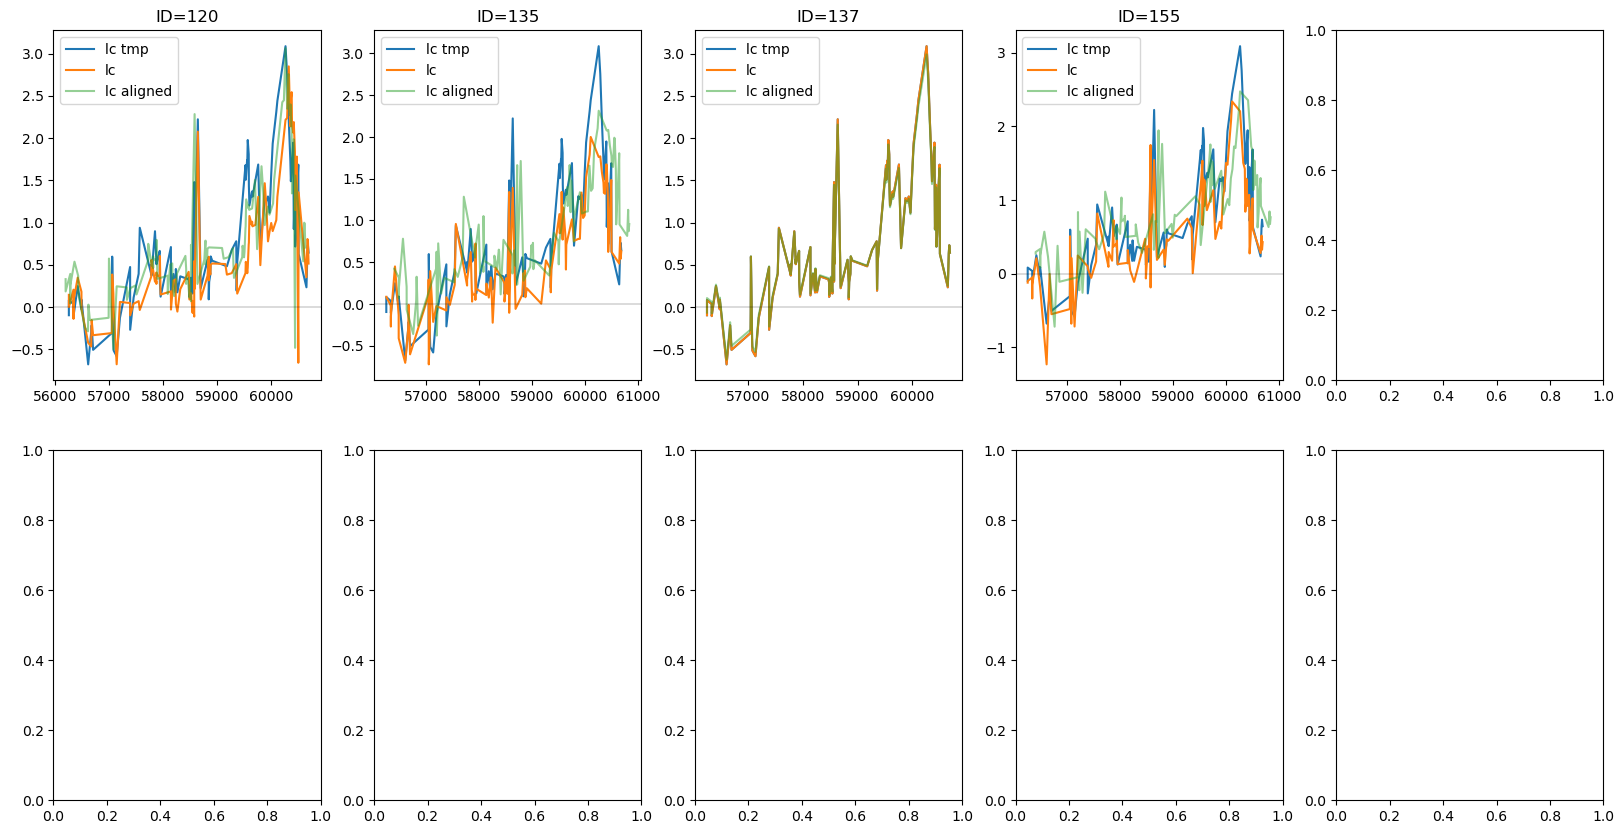

In [71]:
# Find the shift and fitting parameters for each light curve compared to the first one

temp_i = np.where(np.array(IDs_good_fits_57)==137)[0][0]
temp_ID = df_list2[temp_i]['ID'][0]
g1_inds = lc_indices(df_list2[temp_i], n_sigma=n_sigma2, nerr_sigma=nerr_sigma2)
t1 = df_list2[temp_i]['mjd'][g1_inds].values
f1 = df_list2[temp_i]['mJyas2'][g1_inds].values
f1_err = df_list2[temp_i]['mJyas2_err'][g1_inds].values


fig, axs = plt.subplots(2, 5, figsize=(20, 10))
axs = axs.flatten() 

tshifts_57 = []
a_norms_57 = []
b_offsets_57 = []

for i, df in enumerate(df_list2):
    g_inds = lc_indices(df, n_sigma=n_sigma2, nerr_sigma=nerr_sigma2)
    t2 = df['mjd'][g_inds].values
    f2 = df['mJyas2'][g_inds].values
    f2_err = df['mJyas2_err'][g_inds].values

    tshift, a, b = get_tshift_scale_offset(t1, f1, f1_err, t2, f2, f2_err)

    tshifts_57.append(tshift)
    a_norms_57.append(a)
    b_offsets_57.append(b)
    
    ax = axs[i]
    ax.plot(t1, f1, label='lc tmp')
    ax.plot(t2, f2, label='lc')
    ax.plot(t2-tshift, f2*a + b, alpha=.5, label='lc aligned')

    #-------
    # ax.axvline(x=57452, color='k', linewidth=.2)
    # ax.axvline(x=56745, color='k', linewidth=.2, label='tmpl')
    ax.axhline(y=0, color='k', linewidth=.2)

    i_ID = str(df['ID'][0])
    ax.legend()
    ax.set_title(f'ID={i_ID}')

plt.show()

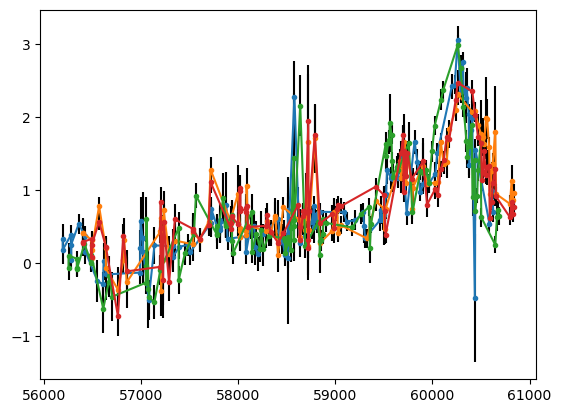

In [73]:
# Find the shift and fitting parameters for each light curve compared to the first one

for i in range(len(tshifts_57)):
    df = df_list2[i]
    i_inds = lc_indices(df, n_sigma=n_sigma2, nerr_sigma=nerr_sigma2)
    
    tshift_i = tshifts_57[i]
    a_i = a_norms_57[i]
    b_i = b_offsets_57[i]
    t_new = df['mjd'][i_inds] - tshift_i
    f_new = a_i*df['mJyas2'][i_inds]+b_i
    ferr_new = a_i*df['mJyas2_err'][i_inds]
    df.loc[i_inds,'new_mjd_1'] = t_new
    df.loc[i_inds,'new_mJyas2_1'] = f_new
    df.loc[i_inds,'new_mJyas2_err_1'] = ferr_new
    plt.errorbar(t_new, f_new, yerr=ferr_new, fmt='.-', ecolor='black')
    # plt.ylim(-3.0e-6,4.0e-6)
# plt.xlim(57650,57800)

In [78]:
### Put combined data into a data frame
tls2 = np.concatenate([i['new_mjd_1'][lc_indices(i, n_sigma=n_sigma2, nerr_sigma=nerr_sigma2)] for i in df_list2])
fls2 = np.concatenate([i['new_mJyas2_1'][lc_indices(i, n_sigma=n_sigma2, nerr_sigma=nerr_sigma2)] for i in df_list2])
ferrls2 = np.concatenate([i['new_mJyas2_err_1'][lc_indices(i, n_sigma=n_sigma2, nerr_sigma=nerr_sigma2)] for i in df_list2])

ord_inds2 = tls2.argsort()
tls2 = tls2[ord_inds2]
fls2 = fls2[ord_inds2]
ferrls2 = ferrls2[ord_inds2]


comb2_data = {'mjd': tls2, 'mJyas2': fls2, 'mJyas2_err': ferrls2}
comb2 = pdastrostatsclass()
comb2.t = comb2.t.assign(**comb2_data)



### Use sigmacutloop function in pdastro to calculate the combined light curve
# bins2, t_bvals2 = get_bins(comb2, tls2)
bins2 = get_LCbins(comb2,20)
tmed2 = []
fmed2 = []
fmed_err2 = []
workinds2 = []
badinds2 = []

for i in range(len(bins2)):
    bin_i = bins2[i]
    comb2.calcaverage_sigmacutloop('mJyas2', indices=bin_i, noisecol='mJyas2_err', percentile_cut_firstiteration=70, Nsigma=3.0)
    tmed2.append(np.average(comb2.t.loc[bin_i,'mjd'], weights=1-comb2.t.loc[bin_i,'mJyas2_err']/max(comb2.t.loc[bin_i,'mJyas2_err'])))
    fmed2.append(comb2.statparams['mean'])
    fmed_err2.append(comb2.statparams['mean_err'])
    workinds2.append(comb2.statparams['ix_good'])
    badinds2.append(comb2.statparams['ix_clip'])


tmed2 = np.array(tmed2)
fmed2 = np.array(fmed2)
fmed_err2 = np.array(fmed_err2)


### Find the peaks in combined light curve
tpeak2 = find_t_peak(tmed2, fmed2)

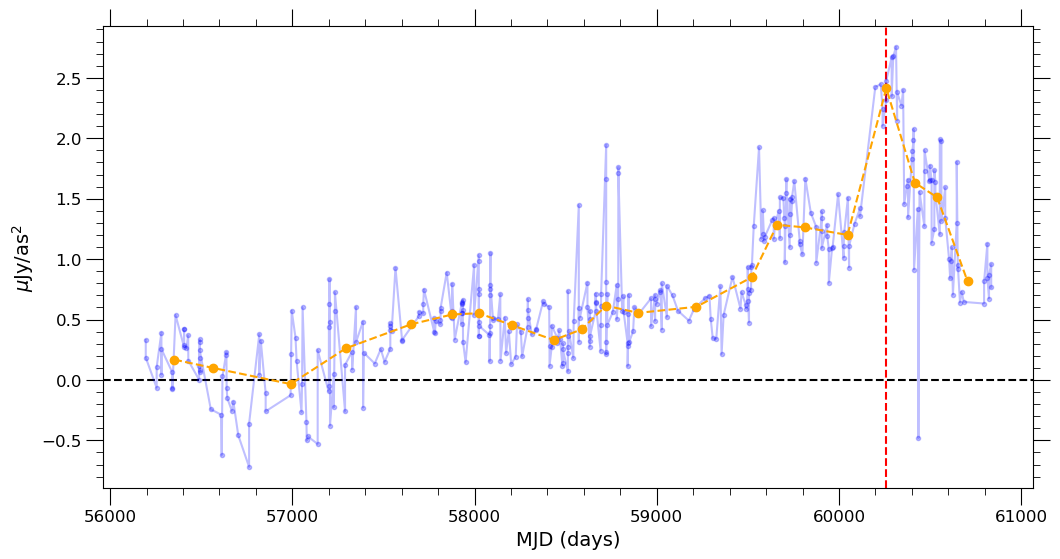

In [80]:
### Plot the combined light curve

pl_fig, pl_ax = plt.subplots(dpi = 100, figsize = [12,6])
pl_ax.minorticks_on()
pl_ax.tick_params(axis='x', labelsize=12)
pl_ax.tick_params(axis='y', labelsize=12)
pl_ax.tick_params(which='major',bottom='on',top='on',left='on',right='on',length=12)
pl_ax.tick_params(which='minor',bottom='on',top='on',left='on',right='on',length=5)
pl_ax.set_xlabel('MJD (days)', fontsize = 14)
pl_ax.set_ylabel('$\mu$Jy/as$^2$', fontsize = 14)
# pl_ax.set_title('Light Curve of filter i', x=0.4, y=0.9, fontsize = 16)
pl_ax.ticklabel_format(axis='both', style='plain')

winds2 = [i for bn in workinds2 for i in bn]

pl_ax.errorbar(comb2.t.loc[winds2,'mjd'], comb2.t.loc[winds2,'mJyas2'], color='blue', fmt='.-', alpha=0.25)
pl_ax.axhline(y=0, linestyle='--', color='black')
pl_ax.errorbar(tmed2,fmed2, fmt='--o', ecolor='black', color='orange') #,yerr=fmed_err2
pl_ax.axvline(x=tpeak2, color='red', linestyle='--')
# pl_ax.legend(fontsize = 14)
# pl_fig.savefig('ec0915_LC2.png', bbox_inches = 'tight', dpi=100)

### Segment 3

In [86]:
### Read in light curves -- ec0915 ccd 54 (comet), focused on tail end

url3 = 'https://stsci-transients.stsci.edu/eta/etalc/results/rod_test/goodpos_g/ec0915/54/ec0915a54_goodpos_g_tmpl523730.html'
html3 = requests.get(url3).content
df_table3 = pd.read_html(html3)[-1]

IDs_comet = [1321, 1322, 1371, 1372, 1421, 1422]

# df_list3 = []
# for i in range(len(df_table3)):
#     group_i = df_table3['group'][i]
#     ID_i = df_table3['ID'][i]

#     if group_i == 0:
#         url = 'https://stsci-transients.stsci.edu/eta/etalc/results/rod_test/goodpos_g/ec0915/54/ec0915a54_goodpos_g_tmpl523730_ID'+str(ID_i)+'_lc.txt'
#         temp_tab = pd.read_csv(url, sep='\s+')
#         df_list3.append(temp_tab)

df_list3 = []
for i in IDs_comet:
    group_i = df_table1['group'][i]
    ID_i = df_table1['ID'][i]
    
    url = 'https://stsci-transients.stsci.edu/eta/etalc/results/rod_test/poly1_g/ec0915/54/ec0915a54_poly1pos_g_tmpl523730_ID'+str(ID_i)+'_lc.txt'
    temp_tab = pd.read_csv(url, sep='\s+')
    df_list3.append(temp_tab)


### Want to work with micro-Jansky
for df in df_list3:
    df['mJyas2'] = df['Jyas2']*1e6
    df['mJyas2_err'] = df['Jyas2_err']*1e6

In [90]:
### Loop through and see the individual light curves
### Figure out uncertainty cuts to find the peaks


n_sigma3 = None
nerr_sigma3 = None

# for df in df_list3:
#     print(df['ID'][0])
    
#     # plt.errorbar(df['mjd'], df['Jyas2'], yerr=df['Jyas2_err'], fmt='o', ecolor='black', color='blue')

#     inds_sig = lc_indices(df, n_sigma=n_sigma3, nerr_sigma=nerr_sigma3)
#     plt.errorbar(df['mjd'][inds_sig], df['mJyas2'][inds_sig], yerr=df['mJyas2_err'][inds_sig], fmt='--o', ecolor='black', color='orange')
    
#     plt.axhline(y=0, linestyle='--', color='black')

#     # peak_t3 = find_t_peak(df['mjd'][inds_sig].values, df['Jyas2'][inds_sig].values)
#     # plt.axvline(x=peak_t3,color='red')
    
#     plt.show()

In [92]:
# ### Template image to get proper flux offset

# tmpl_fits = 'data/testdata/tmpl/54/ec0915.140329.296582_ooi_i_v1_N22.sw.fits'

# with fits.open(tmpl_fits) as tmpl_hdu:
#     tmpl_hdr = tmpl_hdu[0].header
#     tmpl_img = tmpl_hdu[0].data

# tmpl_wcs = WCS(tmpl_hdr)

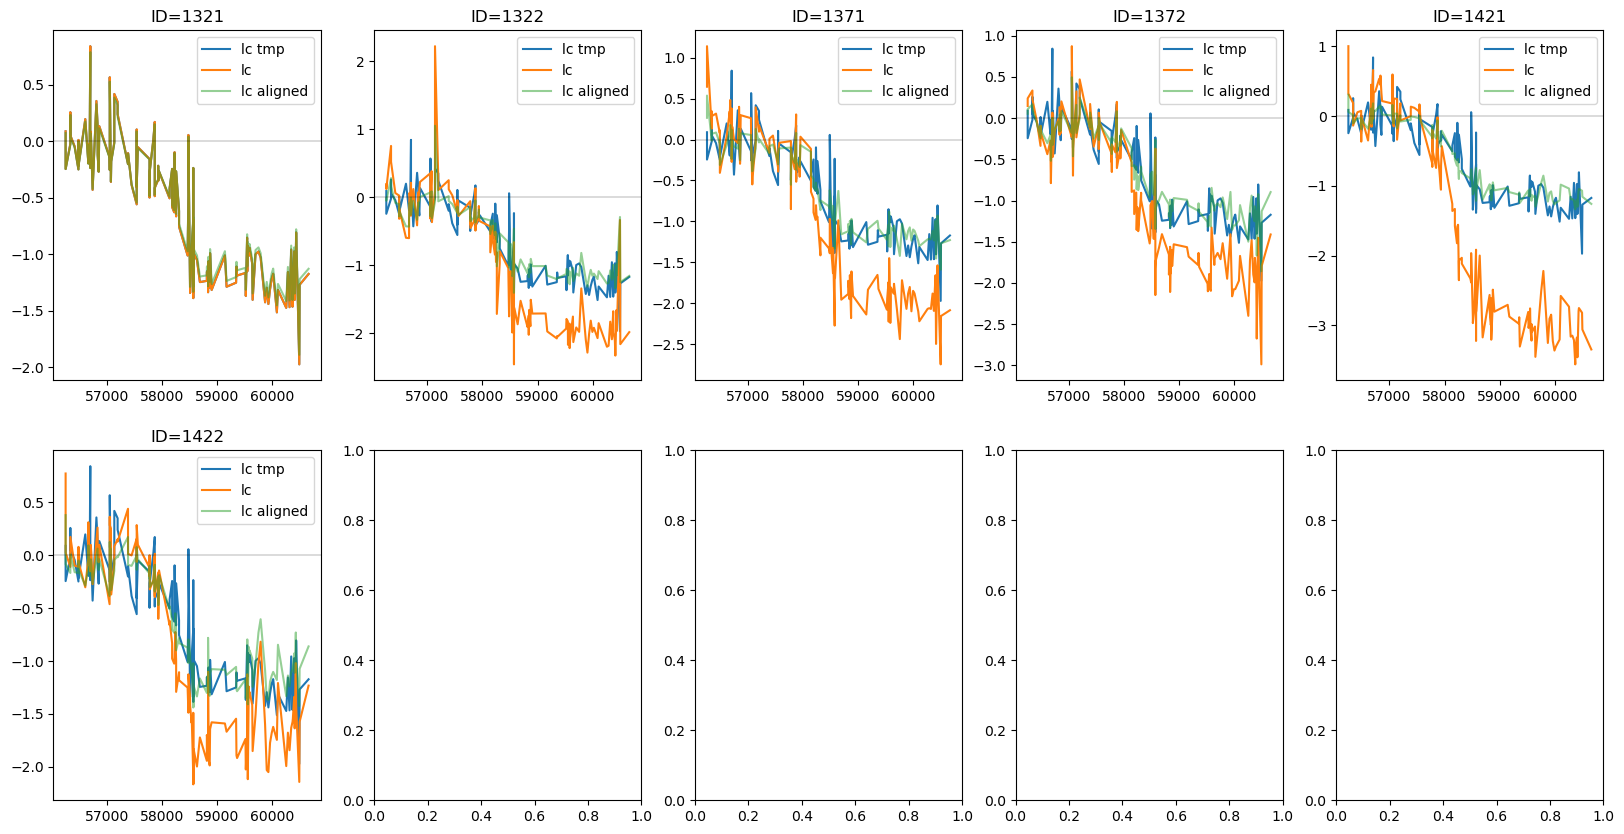

In [94]:
# Find the shift and fitting parameters for each light curve compared to the first one

temp_i = 0
temp_ID = df_list3[temp_i]['ID'][0]
g1_inds = lc_indices(df_list3[temp_i], n_sigma=n_sigma3, nerr_sigma=nerr_sigma3)
t1 = df_list3[temp_i]['mjd'][g1_inds].values
f1 = df_list3[temp_i]['mJyas2'][g1_inds].values
f1_err = df_list3[temp_i]['mJyas2_err'][g1_inds].values


fig, axs = plt.subplots(2, 5, figsize=(20, 10))
axs = axs.flatten() 

tshifts_c = []
a_norms_c = []
b_offsets_c = []

for i, df in enumerate(df_list3):
    g_inds = lc_indices(df, n_sigma=n_sigma3, nerr_sigma=nerr_sigma3)
    t2 = df['mjd'][g_inds].values
    f2 = df['mJyas2'][g_inds].values
    f2_err = df['mJyas2_err'][g_inds].values

    tshift, a, b = get_tshift_scale_offset(t1, f1, f1_err, t2, f2, f2_err, t_peaks=[t1[-1],t2[-1]])

    tshifts_c.append(tshift)
    a_norms_c.append(a)
    b_offsets_c.append(b)
    
    ax = axs[i]
    ax.plot(t1, f1, label='lc tmp')
    ax.plot(t2, f2, label='lc')
    ax.plot(t2-tshift, f2*a + b, alpha=.5, label='lc aligned')

    #-------
    # ax.axvline(x=57452, color='k', linewidth=.2)
    # ax.axvline(x=56745, color='k', linewidth=.2, label='tmpl')
    ax.axhline(y=0, color='k', linewidth=.2)

    i_ID = str(df['ID'][0])
    ax.legend()
    ax.set_title(f'ID={i_ID}')

plt.show()

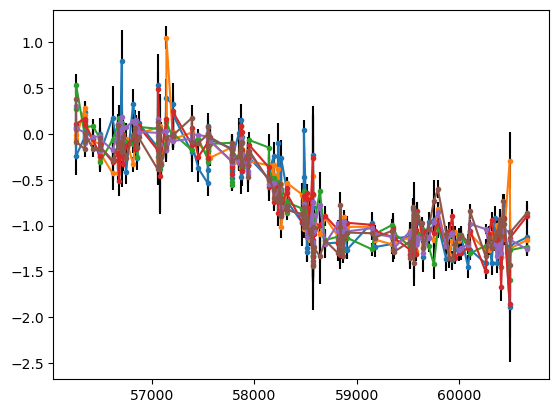

In [96]:
# Find the shift and fitting parameters for each light curve compared to the first one

for i in range(len(tshifts_c)):
    df = df_list3[i]
    i_inds = lc_indices(df, n_sigma=n_sigma3, nerr_sigma=nerr_sigma3)
    
    tshift_i = tshifts_c[i]
    a_i = a_norms_c[i]
    b_i = b_offsets_c[i]
    t_new = df['mjd'][i_inds] - tshift_i
    f_new = a_i*df['mJyas2'][i_inds]+b_i
    ferr_new = a_i*df['mJyas2_err'][i_inds]
    df.loc[i_inds,'new_mjd_1'] = t_new
    df.loc[i_inds,'new_mJyas2_1'] = f_new
    df.loc[i_inds,'new_mJyas2_err_1'] = ferr_new
    plt.errorbar(t_new, f_new, yerr=ferr_new, fmt='.-', ecolor='black')
    # plt.ylim(-3.0e-6,4.0e-6)
# plt.xlim(57650,57800)

In [98]:
# ### Normalize the tail ends; not fitting like before since no peaks, but the tail end should have flux at zero
# ### Normalize by finding spread and multiplying by inverse

# comet_norms = []

# for df in df_list3:
#     inds_sig = lc_indices(df, n_sigma=n_sigma3, nerr_sigma=nerr_sigma3)
#     height = df.loc[inds_sig[:10],'mJyas2'].mean() - df.loc[inds_sig[-30:],'mJyas2'].mean()      # estimate where to get the mean (the two flat ends)
#     a_norm = 1./height
#     comet_norms.append(a_norm)
#     f_new = df['mJyas2'][inds_sig] * a_norm
#     ferr_new = df['mJyas2_err'][inds_sig] * a_norm

#     ### this was done in flux space ...
#     # posx = df['x'][0]      # get x,y position of each light curve
#     # posy = df['y'][0]
#     # pix_mean = get_mean_pix(tmpl_img,posx,posy)      # get mean pix value of light curve position
#     # f_scaled = a_norm * (df['mJyas2'][inds_sig] + pix_mean - 1573)

#     df.loc[inds_sig,'new_mJyas2_1'] = f_new
#     df.loc[inds_sig,'new_mJyas2_err_1'] = ferr_new
#     # df.loc[inds_sig,'scaled_mJyas2_1'] = f_scaled

#     plt.errorbar(df['mjd'][inds_sig], f_new, yerr=ferr_new, fmt='.-', ecolor='black', color='orange')
#     plt.axhline(y=0, linestyle='--', color='black')

In [100]:
### Put combined data into a data frame
tls3 = np.concatenate([i['mjd'][lc_indices(i, n_sigma=n_sigma3, nerr_sigma=nerr_sigma3)] for i in df_list3])
fls3 = np.concatenate([i['new_mJyas2_1'][lc_indices(i, n_sigma=n_sigma3, nerr_sigma=nerr_sigma3)] for i in df_list3])
ferrls3 = np.concatenate([i['new_mJyas2_err_1'][lc_indices(i, n_sigma=n_sigma3, nerr_sigma=nerr_sigma3)] for i in df_list3])

ord_inds3 = tls3.argsort()
tls3 = tls3[ord_inds3]
fls3 = fls3[ord_inds3]
ferrls3 = ferrls3[ord_inds3]


comb3_data = {'mjd': tls3, 'mJyas2': fls3, 'mJyas2_err': ferrls3}
comb3 = pdastrostatsclass()
comb3.t = comb3.t.assign(**comb3_data)


### Use sigmacutloop function in pdastro to calculate the combined light curve
# bins3, t_bvals3 = get_bins(comb3, tls3)
bins3 = get_LCbins(comb3,45)
tmed3 = []
fmed3 = []
fmed_err3 = []
workinds3 = []
badinds3 = []

for i in range(len(bins3)):
    bin_i = bins3[i]
    comb3.calcaverage_sigmacutloop('mJyas2', indices=bin_i, noisecol='mJyas2_err', percentile_cut_firstiteration=70, Nsigma=3.0)
    tmed3.append(np.average(comb3.t.loc[bin_i,'mjd'], weights=1-comb3.t.loc[bin_i,'mJyas2_err']/max(comb3.t.loc[bin_i,'mJyas2_err'])))
    fmed3.append(comb3.statparams['mean'])
    fmed_err3.append(comb3.statparams['mean_err'])
    workinds3.append(comb3.statparams['ix_good'])
    badinds3.append(comb3.statparams['ix_clip'])


tmed3 = np.array(tmed3)
fmed3 = np.array(fmed3)
fmed_err3 = np.array(fmed_err3)

<ErrorbarContainer object of 3 artists>

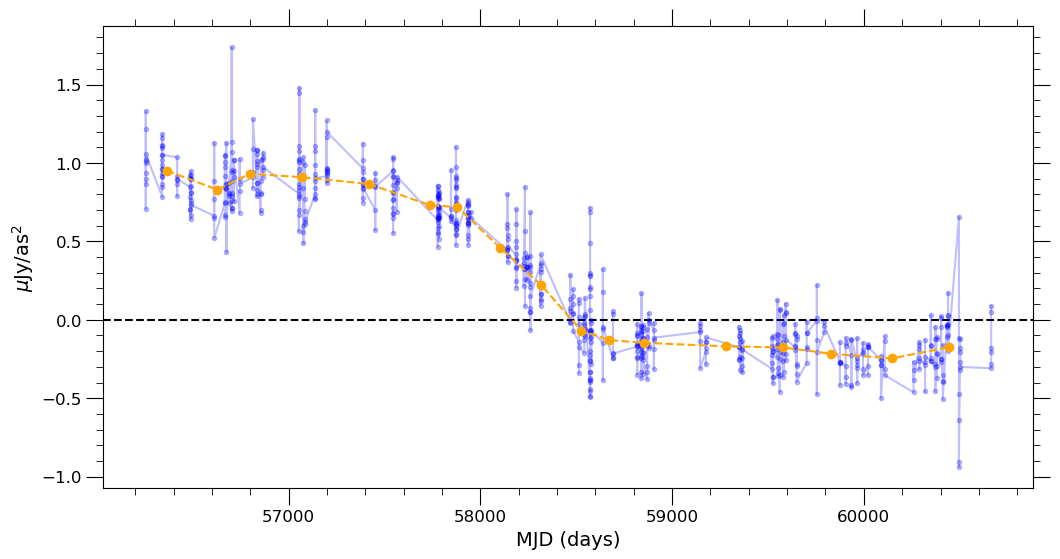

In [101]:
### Plot the combined light curve

pl_fig, pl_ax = plt.subplots(dpi = 100, figsize = [12,6])
pl_ax.minorticks_on()
pl_ax.tick_params(axis='x', labelsize=12)
pl_ax.tick_params(axis='y', labelsize=12)
pl_ax.tick_params(which='major',bottom='on',top='on',left='on',right='on',length=12)
pl_ax.tick_params(which='minor',bottom='on',top='on',left='on',right='on',length=5)
pl_ax.set_xlabel('MJD (days)', fontsize = 14)
pl_ax.set_ylabel('$\mu$Jy/as$^2$', fontsize = 14)
# pl_ax.set_title('Light Curve of filter i', x=0.4, y=0.9, fontsize = 16)
pl_ax.ticklabel_format(axis='both', style='plain')

winds3 = [i for bn in workinds3 for i in bn]

f_offset = 0.95

pl_ax.errorbar(comb3.t.loc[winds3,'mjd'], comb3.t.loc[winds3,'mJyas2']+f_offset, color='blue', fmt='.-', alpha=0.25)
pl_ax.axhline(y=0, linestyle='--', color='black')
pl_ax.errorbar(tmed3, fmed3+f_offset, fmt='--o', ecolor='black', color='orange') #,yerr=fmed_err3
# pl_ax.axvline(x=tpeak3, color='red', linestyle='--')
# pl_ax.legend(fontsize = 14)

# pl_fig.savefig('ec0915_LC3.png', bbox_inches = 'tight', dpi=100)

### Segment 4

In [108]:
### Read in light curves -- Armin positions, focused on plateau

url4 = 'https://stsci-transients.stsci.edu/eta/etalc/results/rod_test/Armins_g/ec0915/54/ec0915a54_Arminspos_g_tmpl523730.html'
html4 = requests.get(url4).content
df_table4 = pd.read_html(html4)[-1]

df_list4 = []
for i in range(len(df_table4)):
    url = 'https://stsci-transients.stsci.edu/eta/etalc/results/rod_test/Armins_g/ec0915/54/ec0915a54_Arminspos_g_tmpl523730_ID'+str(i)+'_lc.txt'
    temp_tab = pd.read_csv(url, sep='\s+')
    df_list4.append(temp_tab)


### Want to work with micro-Jansky
for df in df_list4:
    df['mJyas2'] = df['Jyas2']*1e6
    df['mJyas2_err'] = df['Jyas2_err']*1e6

0


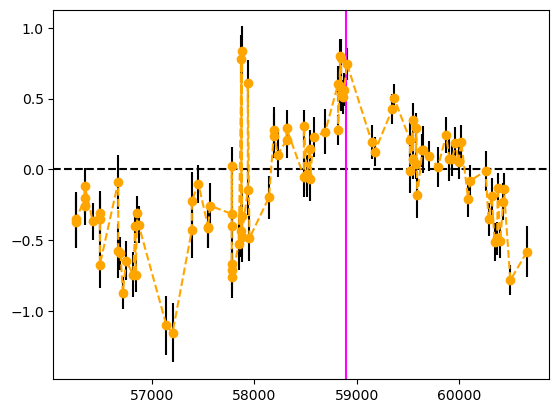

1


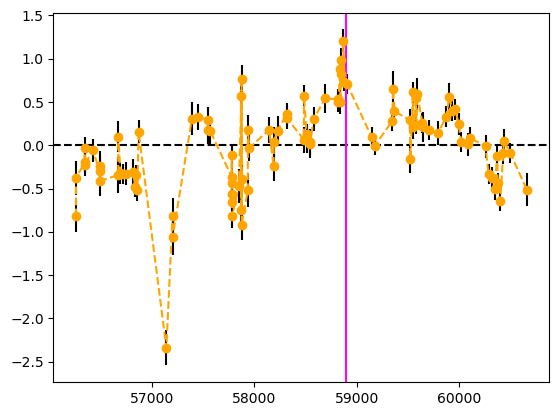

2


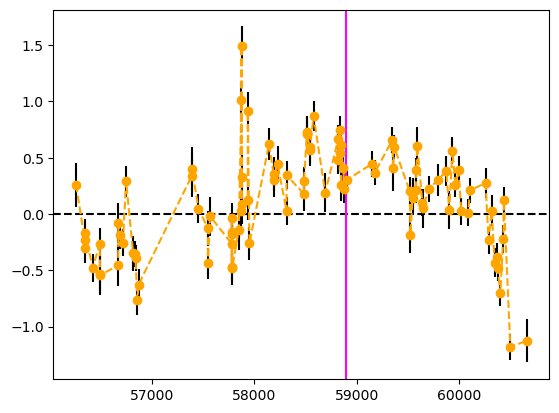

3


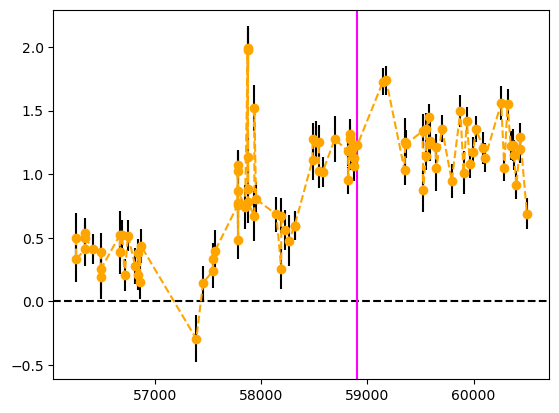

In [357]:
### Loop through and see the individual light curves
### Figure out uncertainty cuts


n_sigma4 = 10.0
nerr_sigma4 = 0.5

for df in df_list4:
    print(df['ID'][0])
    
    # plt.errorbar(df['mjd'], df['mJyas2'], yerr=df['mJyas2_err'], fmt='o', ecolor='black', color='blue')

    inds_sig = lc_indices(df, n_sigma=n_sigma4, nerr_sigma=nerr_sigma4)
    plt.errorbar(df['mjd'][inds_sig], df['mJyas2'][inds_sig], yerr=df['mJyas2_err'][inds_sig], fmt='--o', ecolor='black', color='orange')
    
    plt.axhline(y=0, linestyle='--', color='black')

    # peak_t4 = find_t_peak(df['mjd'][inds_sig].values, df['mJyas2'][inds_sig].values, t_range=[57200,57900])
    # plt.axvline(x=peak_t4,color='red')
    plt.axvline(x=58900,color='magenta')
    
    plt.show()

t_peaks_locs = [58900, 58900, 59000, 59150]
# t_peaks_locs = [57180, 57140, 56875, 57380]

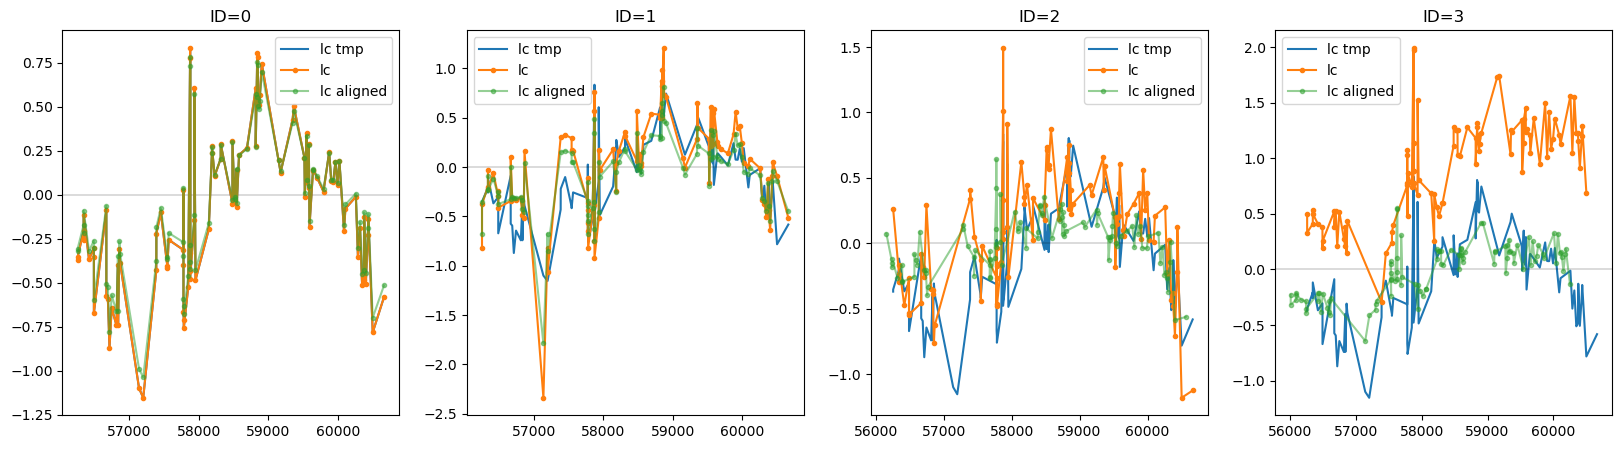

In [308]:
# Find the shift and fitting parameters for each light curve compared to the segment 1
temp_i = 0
temp_ID = df_list4[temp_i]['ID'][0]
g1_inds = lc_indices(df_list4[temp_i], n_sigma=n_sigma4, nerr_sigma=nerr_sigma4)
t1 = df_list4[temp_i]['mjd'][g1_inds].values
f1 = df_list4[temp_i]['mJyas2'][g1_inds].values
f1_err = df_list4[temp_i]['mJyas2_err'][g1_inds].values
tp_loc1 = t_peaks_locs[0]


fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs = axs.flatten() 

tshifts_A = []
a_norms_A = []
b_offsets_A = []

for i, df in enumerate(df_list4):
    g_inds = lc_indices(df, n_sigma=n_sigma4, nerr_sigma=nerr_sigma4)
    t2 = df['mjd'][g_inds].values
    f2 = df['mJyas2'][g_inds].values
    f2_err = df['mJyas2_err'][g_inds].values
    tp_loc2 = t_peaks_locs[i]

    tshift, a, b = get_tshift_scale_offset(t1, f1, f1_err, t2, f2, f2_err, t_peaks=[tp_loc1, tp_loc2])
    
    tshifts_A.append(tshift)
    a_norms_A.append(a)
    b_offsets_A.append(b)
    
    ax = axs[i]
    ax.plot(t1, f1, label='lc tmp')
    ax.errorbar(t2, f2, label='lc', fmt='.-')
    ax.errorbar(t2-tshift, f2*a + b, alpha=.5, label='lc aligned', fmt='.-')

    #-------
    # ax.axvline(x=57452, color='k', linewidth=.2)
    # ax.axvline(x=56745, color='k', linewidth=.2, label='tmpl')
    ax.axhline(y=0, color='k', linewidth=.2)

    i_ID = str(df['ID'][0])
    ax.legend()
    ax.set_title(f'ID={i_ID}')

plt.show()

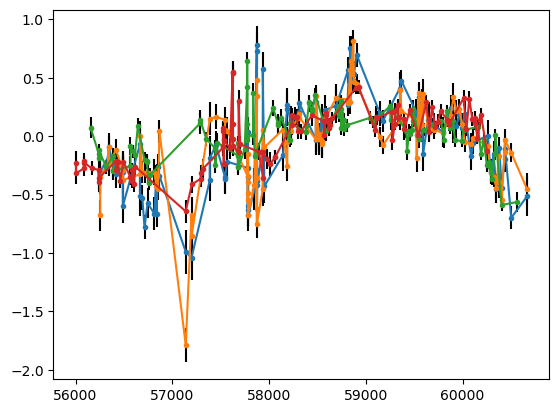

In [310]:
for i in range(len(tshifts_A)):
    df = df_list4[i]
    i_inds = lc_indices(df, n_sigma=n_sigma4, nerr_sigma=nerr_sigma4)
    
    tshift_i = tshifts_A[i]
    a_i = a_norms_A[i]
    b_i = b_offsets_A[i]
    t_new = df['mjd'][i_inds] - tshift_i
    f_new = a_i*df['mJyas2'][i_inds]+b_i
    ferr_new = a_i*df['mJyas2_err'][i_inds]
    df.loc[i_inds,'new_mjd_1'] = t_new
    df.loc[i_inds,'new_mJyas2_1'] = f_new
    df.loc[i_inds,'new_mJyas2_err_1'] = ferr_new
    plt.errorbar(t_new, f_new, yerr=ferr_new, fmt='.-', ecolor='black')
    # plt.ylim(-3.0e-6,4.0e-6)
# plt.xlim(57650,57800)

In [312]:
### Put combined data into a data frame
### These positions don't have clear peaks, and are aligned well for the most part so just combined

# tls4 = np.concatenate([i['mjd'][lc_indices(i, n_sigma=n_sigma4, nerr_sigma=nerr_sigma4)] for i in df_list4[:3]])   # skip last one due to larger difference
# fls4 = np.concatenate([i['mJyas2'][lc_indices(i, n_sigma=n_sigma4, nerr_sigma=nerr_sigma4)] for i in df_list4[:3]])
# ferrls4 = np.concatenate([i['mJyas2_err'][lc_indices(i, n_sigma=n_sigma4, nerr_sigma=nerr_sigma4)] for i in df_list4[:3]])

tls4 = np.concatenate([i['new_mjd_1'][lc_indices(i, n_sigma=n_sigma4, nerr_sigma=nerr_sigma4)] for i in df_list4])
fls4 = np.concatenate([i['new_mJyas2_1'][lc_indices(i, n_sigma=n_sigma4, nerr_sigma=nerr_sigma4)] for i in df_list4])
ferrls4 = np.concatenate([i['new_mJyas2_err_1'][lc_indices(i, n_sigma=n_sigma4, nerr_sigma=nerr_sigma4)] for i in df_list4])

ord_inds4 = tls4.argsort()
tls4 = tls4[ord_inds4]
fls4 = fls4[ord_inds4]
ferrls4 = ferrls4[ord_inds4]


comb4_data = {'mjd': tls4, 'mJyas2': fls4, 'mJyas2_err': ferrls4}
comb4 = pdastrostatsclass()
comb4.t = comb4.t.assign(**comb4_data)



### Use sigmacutloop function in pdastro to calculate the combined light curve
# bins4, t_bvals4 = get_bins(comb4, tls4)
bins4 = get_LCbins(comb4, 25)
tmed4 = []
fmed4 = []
fmed_err4 = []
workinds4 = []
badinds4 = []

for i in range(len(bins4)):
    bin_i = bins4[i]
    comb4.calcaverage_sigmacutloop('mJyas2', indices=bin_i, noisecol='mJyas2_err', percentile_cut_firstiteration=70, Nsigma=3.0)
    tmed4.append(np.average(comb4.t.loc[bin_i,'mjd'], weights=1-comb4.t.loc[bin_i,'mJyas2_err']/max(comb4.t.loc[bin_i,'mJyas2_err'])))
    fmed4.append(comb4.statparams['mean'])
    fmed_err4.append(comb4.statparams['mean_err'])
    workinds4.append(comb4.statparams['ix_good'])
    badinds4.append(comb4.statparams['ix_clip'])


tmed4 = np.array(tmed4)
fmed4 = np.array(fmed4)
fmed_err4 = np.array(fmed_err4)

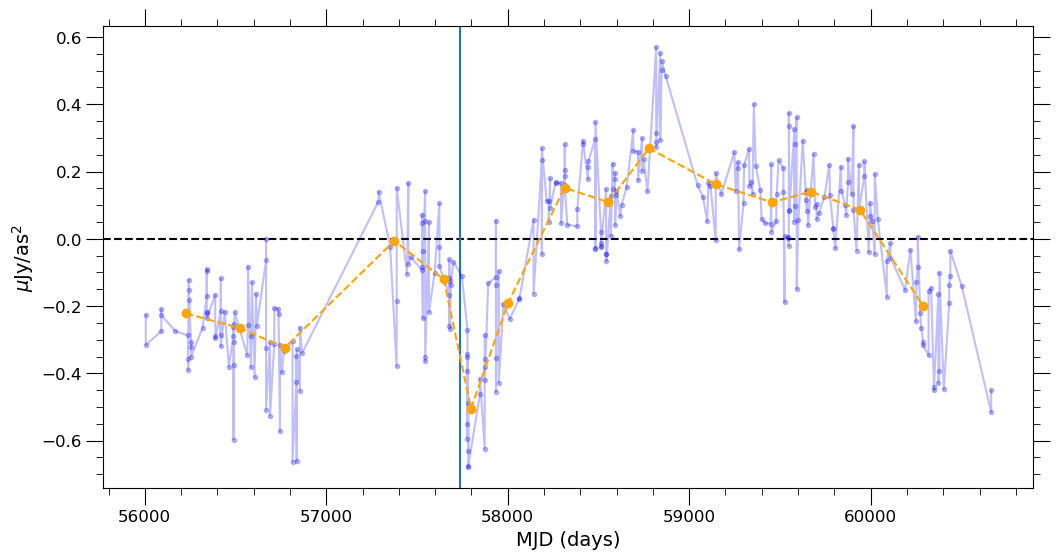

In [316]:
### Plot the combined light curve

pl_fig, pl_ax = plt.subplots(dpi = 100, figsize = [12,6])
pl_ax.minorticks_on()
pl_ax.tick_params(axis='x', labelsize=12)
pl_ax.tick_params(axis='y', labelsize=12)
pl_ax.tick_params(which='major',bottom='on',top='on',left='on',right='on',length=12)
pl_ax.tick_params(which='minor',bottom='on',top='on',left='on',right='on',length=5)
pl_ax.set_xlabel('MJD (days)', fontsize = 14)
pl_ax.set_ylabel('$\mu$Jy/as$^2$', fontsize = 14)
# pl_ax.set_title('Light Curve of filter i', x=0.4, y=0.9, fontsize = 16)
pl_ax.ticklabel_format(axis='both', style='plain')

winds4 = [i for bn in workinds4 for i in bn]

pl_ax.errorbar(comb4.t.loc[winds4,'mjd'], comb4.t.loc[winds4,'mJyas2'], color='blue', fmt='.-', alpha=0.25)
pl_ax.axhline(y=0, linestyle='--', color='black')
pl_ax.errorbar(tmed4, fmed4, fmt='--o', ecolor='black', color='orange') #,yerr=fmed_err4
# pl_ax.legend(fontsize = 14)

# pl_fig.savefig('ec0915_LC4.png', bbox_inches = 'tight', dpi=100)

pl_ax.axvline(57735)

### Combine Segments -- Get LC_0 (the model)

<ErrorbarContainer object of 3 artists>

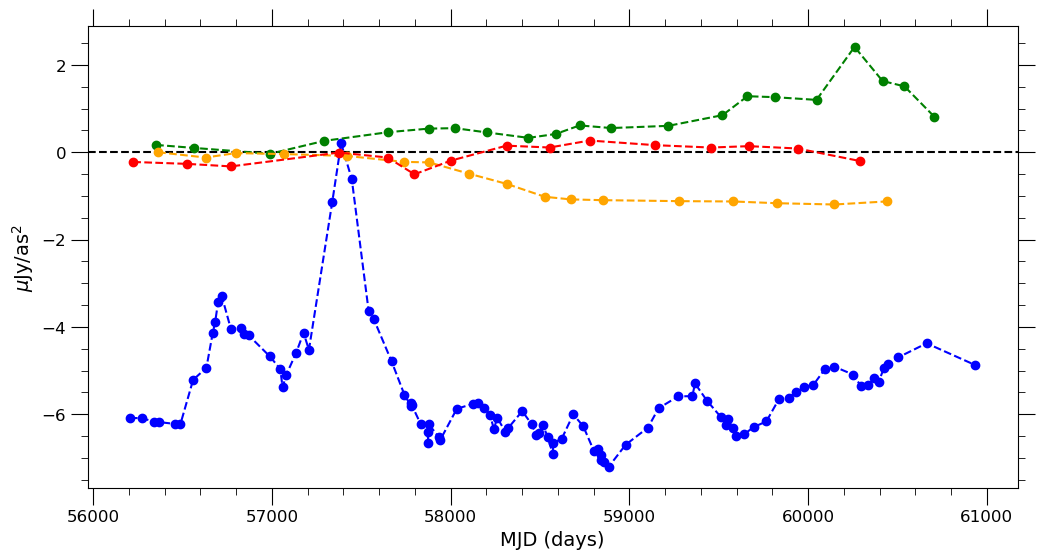

In [320]:
### Plot all the segments

pl_fig, pl_ax = plt.subplots(dpi = 100, figsize = [12,6])
pl_ax.minorticks_on()
pl_ax.tick_params(axis='x', labelsize=12)
pl_ax.tick_params(axis='y', labelsize=12)
pl_ax.tick_params(which='major',bottom='on',top='on',left='on',right='on',length=12)
pl_ax.tick_params(which='minor',bottom='on',top='on',left='on',right='on',length=5)
pl_ax.set_xlabel('MJD (days)', fontsize = 14)
pl_ax.set_ylabel('$\mu$Jy/as$^2$', fontsize = 14)
# pl_ax.set_title('Light Curve of filter i', x=0.4, y=0.9, fontsize = 16)
pl_ax.ticklabel_format(axis='both', style='plain')

# pl_ax.scatter(comb1.t.loc[:,'mjd'], comb1.t.loc[:,'Jyas2'], color='blue', alpha=0.25)
# pl_ax.scatter(comb2.t.loc[:,'mjd'], comb2.t.loc[:,'Jyas2'], color='green', alpha=0.25)
# pl_ax.scatter(comb3.t.loc[:,'mjd'], comb3.t.loc[:,'Jyas2'], color='orange', alpha=0.25)
# pl_ax.scatter(comb4.t.loc[:,'mjd'], comb4.t.loc[:,'Jyas2'], color='red', alpha=0.25)
pl_ax.axhline(y=0, linestyle='--', color='black')

pl_ax.errorbar(tmed1, fmed1, fmt='--o', ecolor='black', color='blue')
pl_ax.errorbar(tmed2, fmed2, fmt='--o', ecolor='black', color='green')
pl_ax.errorbar(tmed3, fmed3, fmt='--o', ecolor='black', color='orange')
pl_ax.errorbar(tmed4, fmed4, fmt='--o', ecolor='black', color='red')

# pl_fig.savefig('ec0915_all.png', bbox_inches = 'tight', dpi=100)

In [326]:
tshiftm12, am12, bm12 = get_tshift_scale_offset(tmed1, fmed1, fmed_err1, tmed2, fmed2, fmed_err2)

tpeakm13 = [60670, tmed3[0]]
tshiftm13, am13, bm13 = get_tshift_scale_offset(tmed1, fmed1, fmed_err1, tmed3, fmed3, fmed_err3, t_peaks=tpeakm13)

tpeakm14 = [59625, 57798]
# tpeakm14 = [59365, 57735]
tshiftm14, am14, bm14 = get_tshift_scale_offset(tmed1, fmed1, fmed_err1, tmed4, fmed4, fmed_err4, t_peaks=tpeakm14)

<ErrorbarContainer object of 3 artists>

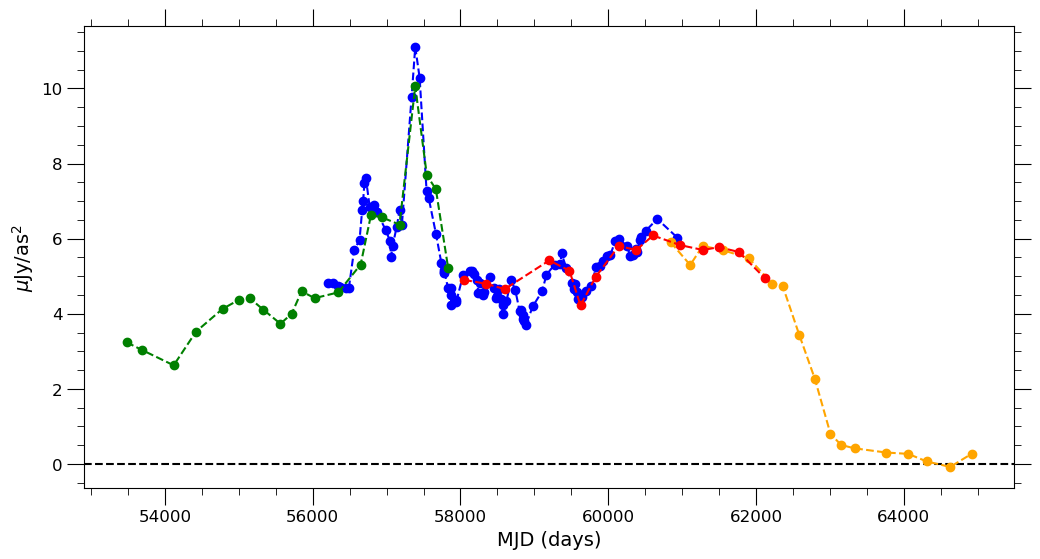

In [332]:

# offsetm = 9.4     # without fitting in segment 3
offsetm = 10.9

m_t1 = tmed1
m_f1 = fmed1+offsetm
m_ferr1 = fmed_err1

m_t2 = tmed2-tshiftm12
m_f2 = (am12*fmed2+bm12)+offsetm
m_ferr2 = am12*fmed_err2

# m_t3 = tmed3+4300
# m_f3 = (5*fmed3-4.65)+offsetm     # without fitting in segment 3
# m_t3 = tmed3-tshiftm13
# m_f3 = (am13*fmed3+bm13)+offsetm  # fitting model segment 3
m_t3 = tmed3+4480
m_f3 = (5.*fmed3-5.)+offsetm        # fitting in segment 3
m_ferr3 = 5.*fmed_err3

# m_t4 = tmed4+1820
# m_f4 = (3.*fmed4-5.2)              # previous version without fitting in segment 3
m_t4 = tmed4-tshiftm14
m_f4 = (am14*fmed4+bm14)+offsetm      # fitting models of segments 1 and 4


pl_fig, pl_ax = plt.subplots(dpi = 100, figsize = [12,6])
pl_ax.minorticks_on()
pl_ax.tick_params(axis='x', labelsize=12)
pl_ax.tick_params(axis='y', labelsize=12)
pl_ax.tick_params(which='major',bottom='on',top='on',left='on',right='on',length=12)
pl_ax.tick_params(which='minor',bottom='on',top='on',left='on',right='on',length=5)
pl_ax.set_xlabel('MJD (days)', fontsize = 14)
pl_ax.set_ylabel('$\mu$Jy/as$^2$', fontsize = 14)
# pl_ax.set_title('Light Curve of filter i', x=0.4, y=0.9, fontsize = 16)
pl_ax.ticklabel_format(axis='both', style='plain')


pl_ax.axhline(y=0, linestyle='--', color='black')

pl_ax.errorbar(m_t1, m_f1, fmt='--o', ecolor='black', color='blue')
pl_ax.errorbar(m_t2, m_f2, fmt='--o', ecolor='black', color='green')
pl_ax.errorbar(m_t3, m_f3, fmt='--o', ecolor='black', color='orange')
pl_ax.errorbar(m_t4, m_f4, fmt='--o', ecolor='black', color='red')


# pl_fig.savefig('ec0915_all.png', bbox_inches = 'tight', dpi=100)

In [334]:
model_t = np.concatenate([m_t1, m_t2, m_t3, m_t4])
model_f = np.concatenate([m_f1, m_f2, m_f3, m_f4])
model_ferr = np.concatenate([m_ferr1, m_ferr2, m_ferr3, m_ferr4])

ord_inds = model_t.argsort()
model_t = model_t[ord_inds]
model_f = model_f[ord_inds]
model_ferr = model_ferr[ord_inds]

In [336]:
fin_t1 = comb1.t.loc[winds1,'mjd'].values
fin_f1 = comb1.t.loc[winds1,'mJyas2'].values+offsetm
fin_ferr1 = comb1.t.loc[winds1,'mJyas2_err'].values

fin_t2 = comb2.t.loc[winds2,'mjd'].values-tshiftm12
fin_f2 = (am12*comb2.t.loc[winds2,'mJyas2'].values+bm12)+offsetm
fin_ferr2 = am12*comb2.t.loc[winds2,'mJyas2_err'].values

fin_t3 = comb3.t.loc[winds3,'mjd'].values+4480
fin_f3 = (5*comb3.t.loc[winds3,'mJyas2'].values-5.)+offsetm
fin_ferr3 = 5*comb3.t.loc[winds3,'mJyas2_err'].values

fin_t4 = comb4.t.loc[winds4,'mjd'].values+1827
fin_f4 = (am14*comb4.t.loc[winds4,'mJyas2'].values+bm14)+offsetm
fin_ferr4 = am14*comb4.t.loc[winds4,'mJyas2_err'].values


tlsm = np.concatenate([fin_t1, fin_t2, fin_t3, fin_t4])
flsm = np.concatenate([fin_f1, fin_f2, fin_f3, fin_f4])
ferrlsm = np.concatenate([fin_ferr1, fin_ferr2, fin_ferr3, fin_ferr4])


ord_indsm = tlsm.argsort()
tlsm = tlsm[ord_indsm]
flsm = flsm[ord_indsm]
ferrlsm = ferrlsm[ord_indsm]


combm_data = {'mjd': tlsm, 'mJyas2': flsm, 'mJyas2_err': ferrlsm}
combm = pdastrostatsclass()
combm.t = combm.t.assign(**combm_data)

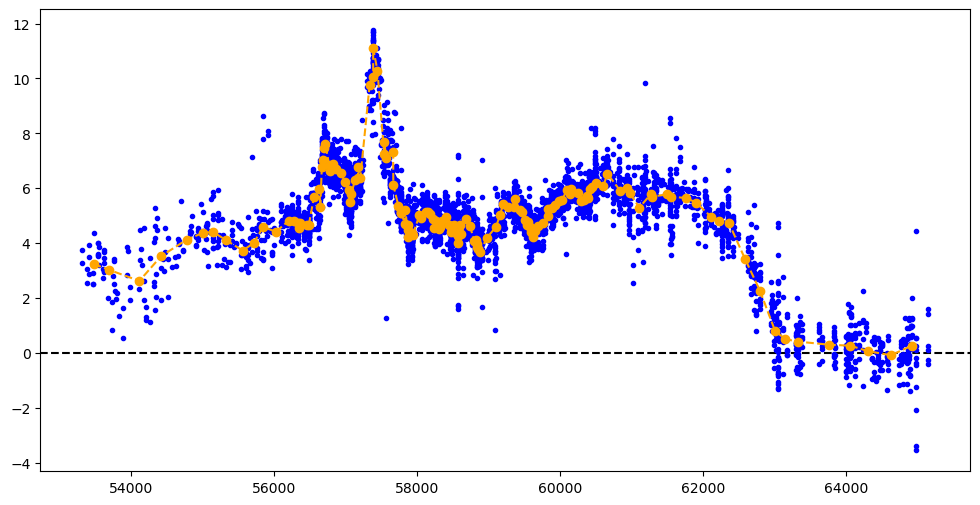

In [348]:
plt.subplots(dpi = 100, figsize = [12,6])
plt.errorbar(combm.t['mjd'], combm.t['mJyas2'], fmt='.', ecolor='black', color='blue')
plt.errorbar(model_t, model_f, fmt='--o', ecolor='black', color='orange')
plt.axhline(y=0, linestyle='--', color='black')

In [350]:
gmodel = {'mjd':model_t, 'mJyas2':model_f, 'mJyas2_err':model_ferr}
gmodel_d = pd.DataFrame(gmodel)

In [351]:
gmodel_d.to_csv('ecLCg_m1.csv', index=False)